# Demonstrate adding day and night to a scada dataframe

This notebook shows how, given lat/long and UTC time, a column with a boolean is_day value is added
This can be useful for a quick partinioning of the data into these two bins

In [2]:

from pathlib import Path
import pandas as pd


from flasc.dataframe_operations.dataframe_manipulations import is_day_or_night, plot_sun_altitude_with_day_night_color


In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from floris.tools import FlorisInterface

import flasc.model_tuning.floris_tuning as ft
from flasc.model_tuning.tuner_utils import set_fi_param, resim_floris
from flasc.energy_ratio.energy_ratio_input import EnergyRatioInput
from flasc.energy_ratio import energy_ratio as er

from flasc.utilities_examples import load_floris_smarteole

import flasc.floris_tools as ftools

In [15]:
# Suppress warnings
import warnings

warnings.filterwarnings('ignore')

# Step 0: (Demo day/night) Load processed data and reduce to first 5000 rows

Load the processed SCADA data with power curve filtering and northing calibration applied and inspect

In [7]:

root_path = Path.cwd()
f = root_path / "postprocessed" / "df_scada_data_60s_filtered_and_northing_calibrated.ftr"
df_scada = pd.read_feather(f)

# To make plots easier to read, limit to first 5000 points
df_scada = df_scada.iloc[:5000]

## Add is_day flag

Use the approximate lat/long of the wind farm to identify day/night using sun altitude

In [8]:
latitude = 49.8435
longitude = 2.801556

df_scada = is_day_or_night(df_scada, 
                    latitude, 
                    longitude)


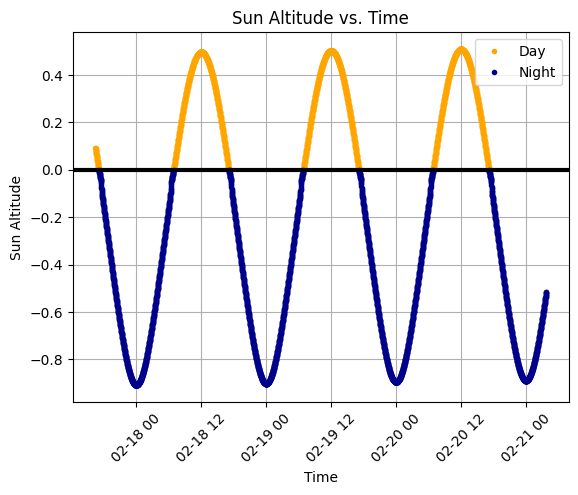

In [9]:
# Plot the day/night columns
plot_sun_altitude_with_day_night_color(df_scada)

## Use the ability to add a time lag

In this example set day as 1 hour after sunrse, and night as 1 hour after sunset

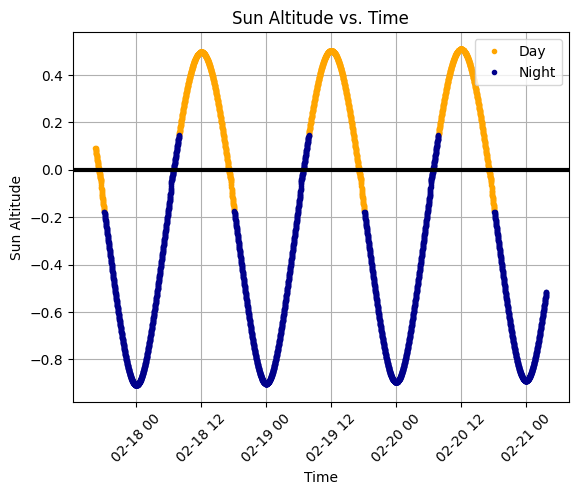

In [10]:
# Try using the lag hour to define daytime as starting 1 hour after dawn
df_scada = is_day_or_night(df_scada, 
                    latitude, 
                    longitude,
                    lag_hours=1)

plot_sun_altitude_with_day_night_color(df_scada)

# Step 1: Add day-night flag to full dataframe

In [12]:
lag_hours = 0

In [38]:
df_scada = pd.read_feather(f)

df_scada = is_day_or_night(df_scada, 
                    latitude, 
                    longitude,
                    lag_hours=lag_hours)

In [39]:
# Limit SCADA data to region of wake steering

# Specify offsets
start_of_offset = 200 # deg
end_of_offset = 240 # deg

# Limit SCADA to this region
df_scada = df_scada[(df_scada.wd_smarteole > (start_of_offset-20)) &
                    (df_scada.wd_smarteole < (end_of_offset+20))]

In [40]:
# Assign wd, ws and pow ref and subset SCADA based on reference variables used in the SMARTEOLE wake steering experiment (TODO reference the experiment)
df_scada = (df_scada
    .assign(
        wd = lambda df_: df_['wd_smarteole'],
        ws = lambda df_: df_['ws_smarteole'],
        pow_ref = lambda df_: df_['pow_ref_smarteole']
    )
)

In [41]:
# For tuning grab the reference, control and test turbines
ref_turbs = [0, 1, 2, 6]
test_turbs = [4]
control_turbs = [5]

In [42]:
# Split SCADA into baseline and wake steeering (controlled)
df_scada_baseline = df_scada[df_scada.control_mode=='baseline']
df_scada_controlled = df_scada[df_scada.control_mode=='controlled']

In [43]:
df_scada_baseline_day = df_scada_baseline[df_scada_baseline.is_day==True]
df_scada_baseline_night = df_scada_baseline[df_scada_baseline.is_day==False]
df_scada_controlled_day = df_scada_controlled[df_scada_controlled.is_day==True]
df_scada_controlled_night = df_scada_controlled[df_scada_controlled.is_day==False]

# Load the FLORIS model

In [46]:
fi, _ = load_floris_smarteole(wake_model="emgauss")
D = fi.floris.farm.rotor_diameters[0]

## Compare expansion tuning

In [47]:
wake_expansion_rates = np.arange(start=0.0005, 
                                   stop=0.025,
                                   step=0.0005)

### Day Time

In [53]:
df_scada = df_scada_baseline_day.copy()
floris_wake_losses, scada_wake_loss = ft.sweep_velocity_model_parameter_for_overall_wake_losses(
    parameter=['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
    value_candidates=wake_expansion_rates,
    df_scada_in = df_scada,
    fi_in = fi,
    param_idx=0,
    ref_turbines=ref_turbs,
    test_turbines=test_turbs,
    wd_min=200, # FOCUS ON WAKE REGION WITH CONTROL
    wd_max=225 # FOCUS ON WAKE REGION WITH CONTROL
)
print(floris_wake_losses, scada_wake_loss)

[49.95161032 49.81462504 49.6776536  49.54079265 49.40416181 49.26776745
 49.1312838  48.9945243  48.85756659 48.72077702 48.58370208 48.44662295
 48.30970929 48.17257881 48.0352359  47.8978967  47.76026009 47.62240293
 47.48462972 47.34662552 47.20873247 47.07080364 46.93297551 46.79527779
 46.65761618 46.52007768 46.38257656 46.2451175  46.10798665 45.97136683
 45.83509117 45.6992131  45.5638656  45.42878722 45.29385119 45.1591143
 45.02477857 44.89065132 44.75677055 44.62348096 44.49061089 44.35810205
 44.22587267 44.0939082  43.9622673  43.83100428 43.70015828 43.56975903
 43.4398519 ] 44.957492942499606


Text(0, 0.5, 'Percent Wake Loss')

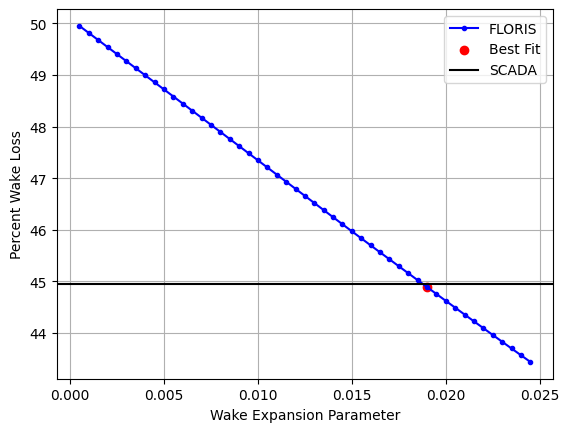

In [54]:
fig, ax = plt.subplots()
best_param_day = ft.select_best_velocity_parameter(floris_wake_losses, 
                   scada_wake_loss,
                   wake_expansion_rates, 
                   ax=ax)
ax.set_xlabel('Wake Expansion Parameter')
ax.set_ylabel('Percent Wake Loss')

### Night Time


In [55]:
df_scada = df_scada_baseline_night.copy()
floris_wake_losses, scada_wake_loss = ft.sweep_velocity_model_parameter_for_overall_wake_losses(
    parameter=['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
    value_candidates=wake_expansion_rates,
    df_scada_in = df_scada,
    fi_in = fi,
    param_idx=0,
    ref_turbines=ref_turbs,
    test_turbines=test_turbs,
    wd_min=200, # FOCUS ON WAKE REGION WITH CONTROL
    wd_max=225 # FOCUS ON WAKE REGION WITH CONTROL
)
print(floris_wake_losses, scada_wake_loss)

[38.39640386 38.27545652 38.15484497 38.03439634 37.91413125 37.79410878
 37.67423665 37.55444662 37.43480383 37.31526304 37.19542327 37.07569206
 36.95601826 36.83614497 36.71629845 36.59657944 36.47691816 36.35721105
 36.2374463  36.11771922 35.9981896  35.87880051 35.7595335  35.64035931
 35.52137558 35.40233657 35.28357698 35.16485319 35.04644816 34.92824204
 34.81024904 34.69269016 34.57535145 34.45828541 34.3415296  34.22526476
 34.10941753 33.99396653 33.87892317 33.76429135 33.65010815 33.53628514
 33.42296768 33.31006151 33.19755573 33.08548348 32.97376756 32.86238915
 32.75134866] 36.309972263002635


Text(0, 0.5, 'Percent Wake Loss')

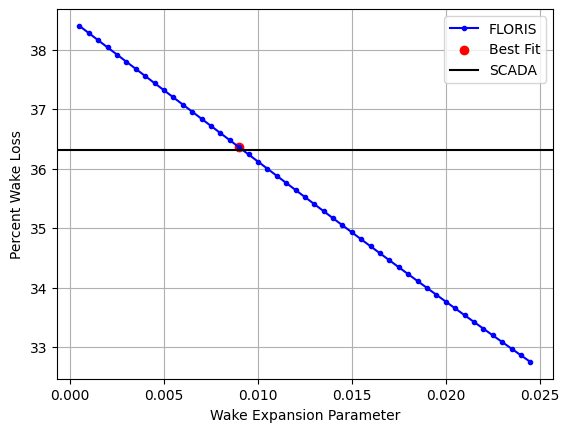

In [56]:
fig, ax = plt.subplots()
best_param_night = ft.select_best_velocity_parameter(floris_wake_losses, 
                   scada_wake_loss,
                   wake_expansion_rates, 
                   ax=ax)
ax.set_xlabel('Wake Expansion Parameter')
ax.set_ylabel('Percent Wake Loss')

In [57]:
## Make models of FLORIS for daytime and night time

In [58]:
fi_day = set_fi_param(fi, 
                      ['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
                      param_idx=0,
                      value=best_param_day)

fi_night = set_fi_param(fi, 
                      ['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
                      param_idx=0,
                      value=best_param_night)

In [59]:
# Resim FLORIS
df_floris_day = resim_floris(fi_day, df_scada_baseline_day)
df_floris_night = resim_floris(fi_night, df_scada_baseline_night)

Text(0.5, 1.0, 'Comparing pre/post tuning FLORIS')

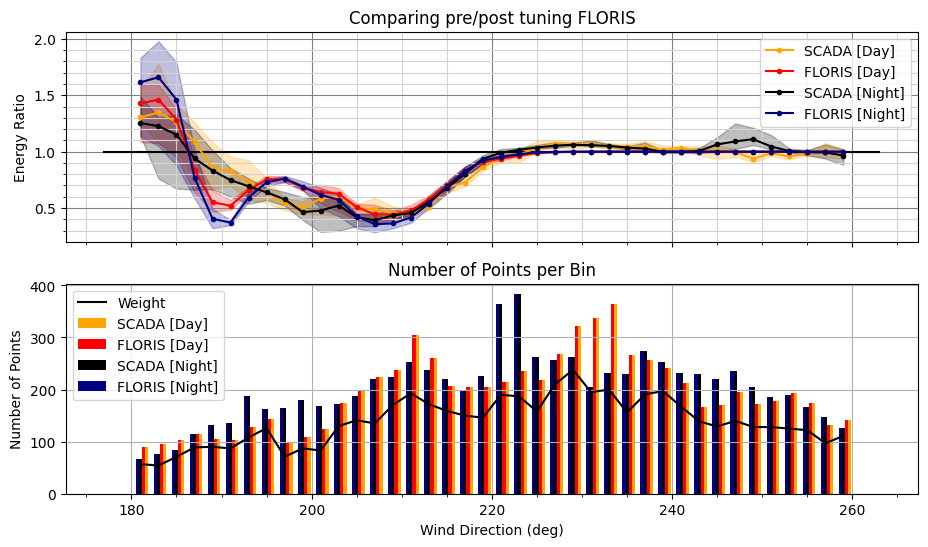

In [62]:
# Compare energy ratios

er_in = EnergyRatioInput(
    [df_scada_baseline_day, df_floris_day, df_scada_baseline_night,df_floris_night ],
    ["SCADA [Day]", "FLORIS [Day]", "SCADA [Night]", "FLORIS [Night]"]
)

er_out = er.compute_energy_ratio(
    er_in,
    ref_turbines=ref_turbs,
    test_turbines=test_turbs,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    ws_step=1.0,
    N=40
)
ax = er_out.plot_energy_ratios(overlay_frequency=True, 
                               color_dict={"SCADA [Day]":'orange',
                                           "FLORIS [Day]":'r',
                                           "SCADA [Night]":'k',
                                           "FLORIS [Night]":'navy',}
                               )
ax[0].set_title("Comparing pre/post tuning FLORIS")



# Horizontal deflection gains

In [72]:
hor_def_gains = np.arange(start=0.25, 
                                   stop=4,
                                   step=0.25)

In [73]:
# Set the yaw angle matrix
yaw_vec_day = df_scada_controlled_day.wind_vane_005
yaw_vec_night = df_scada_controlled_night.wind_vane_005

yaw_angles_day = np.zeros((yaw_vec_day.shape[0],1,7))
yaw_angles_day[:,0,control_turbs[0]] = yaw_vec_day

yaw_angles_night = np.zeros((yaw_vec_night.shape[0],1,7))
yaw_angles_night[:,0,control_turbs[0]] = yaw_vec_night

### Daytime

In [74]:
floris_uplifts, scada_uplift = ft.sweep_deflection_parameter_for_total_uplift(
    parameter = ['wake','wake_deflection_parameters','empirical_gauss','horizontal_deflection_gain_D'],
    value_candidates=hor_def_gains,
    df_scada_baseline_in=df_scada_baseline_day,
    df_scada_wakesteering_in=df_scada_controlled_day,
    fi_in=fi_day,
    ref_turbines=ref_turbs,
    test_turbines=test_turbs,
    yaw_angles_wakesteering=yaw_angles_day,
    ws_min=5,
    wd_min=205,
    wd_max=225
)

Text(0, 0.5, 'Percent Uplift')

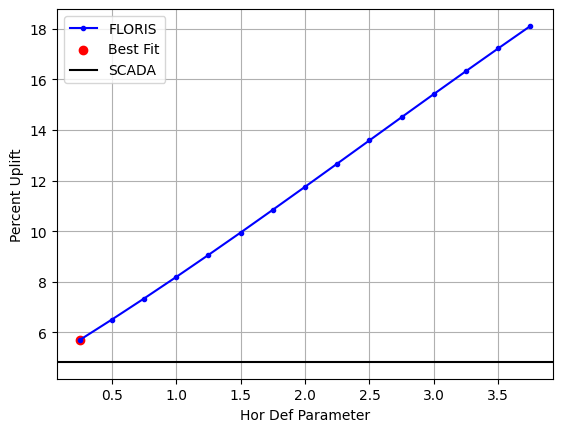

In [75]:

fig, ax = plt.subplots()
best_param_day = ft.select_best_velocity_parameter(floris_uplifts, 
                   scada_uplift,
                   hor_def_gains, 
                   ax=ax)
ax.set_xlabel('Hor Def Parameter')
ax.set_ylabel('Percent Uplift')

### Night-time

In [76]:
floris_uplifts, scada_uplift = ft.sweep_deflection_parameter_for_total_uplift(
    parameter = ['wake','wake_deflection_parameters','empirical_gauss','horizontal_deflection_gain_D'],
    value_candidates=hor_def_gains,
    df_scada_baseline_in=df_scada_baseline_night,
    df_scada_wakesteering_in=df_scada_controlled_night,
    fi_in=fi_night,
    ref_turbines=ref_turbs,
    test_turbines=test_turbs,
    yaw_angles_wakesteering=yaw_angles_night,
    ws_min=5,
    wd_min=205,
    wd_max=225
)

Text(0, 0.5, 'Percent Uplift')

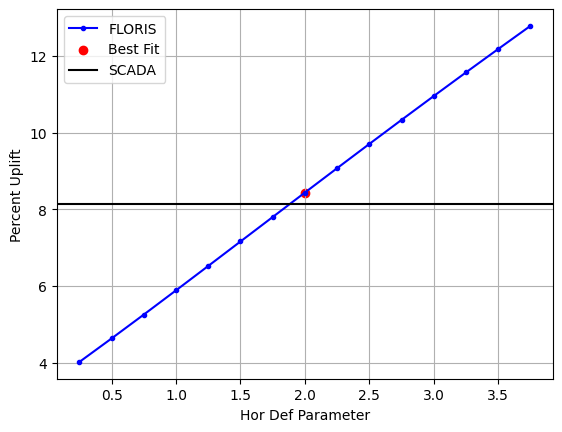

In [77]:
fig, ax = plt.subplots()
best_param = ft.select_best_velocity_parameter(floris_uplifts, 
                   scada_uplift,
                   hor_def_gains, 
                   ax=ax)
ax.set_xlabel('Hor Def Parameter')
ax.set_ylabel('Percent Uplift')